# **SMS and Email Spam Classification**

## Import Libraries

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import nltk
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from plotly.subplots import make_subplots
import plotly.graph_objects as go
nltk.download('stopwords') # for the stop words
# Punkt Sentence Tokenizer
# This tokenizer divides a text into a list of sentences
# by using an unsupervised algorithm to build a model for abbreviation
# words, collocations, and words that start sentences.  It must be
# trained on a large collection of plaintext in the target language
# before it can be used.
# we used it here to get the word and stentence count
nltk.download('punkt')
from nltk.corpus import stopwords
from wordcloud import WordCloud
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\munir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\munir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Preprocessing, Visualization and Cleaning

### Data Preprocessing

#### Read CSV file

In our project, we read the csv file by passing the encoding parmeter, this parmete for is used to read special characters
ref. for more details https://stackoverflow.com/questions/5552555/unicodedecodeerror-invalid-continuation-byte

In [66]:
emailSMSData = pd.read_csv('spam.csv', encoding= 'latin-1') #latin-1 is saperated encoding method for special characters
emailSMSData.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Print Dataframe Info

In [67]:
emailSMSData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


#### Change column name to meaningfull name

In [68]:
# Change the column to be more meaningfull
emailSMSData.columns = ['target','text']

#### Check for NULL values

In [69]:
# Check if there is a null values
emailSMSData.isna().sum()

target    0
text      0
dtype: int64

#### Check for duplicated values

In [70]:
# Check if there is a duplicated values in the data
emailSMSData.duplicated().sum()

403

In [71]:
# Drop the duplicated values from the data
emailSMSData.drop_duplicates(inplace=True)

In [72]:
# Check again for duplicated values
emailSMSData.duplicated().sum()

0

#### Print Description about the data

In [73]:
emailSMSData.describe(exclude='number').T

,count,unique,top,freq
target,5169,2,ham,4516
text,5169,5169,Gud ni8.swt drms.take care,1


### Data Visualization

#### Spam and Ham Count

In [74]:
# Create count plot using plotly
spamHamCount = emailSMSData.groupby(by=["target"]).size().reset_index(name="count")
px.bar(data_frame=spamHamCount, x='target', y='count',
template='plotly_white', color_discrete_sequence=["#73a1c7", "#c47d7d"]).update_layout(title_text='Spam Vs. Ham', title_x=0.5, width=700).show()

#### Word Cloud for each class

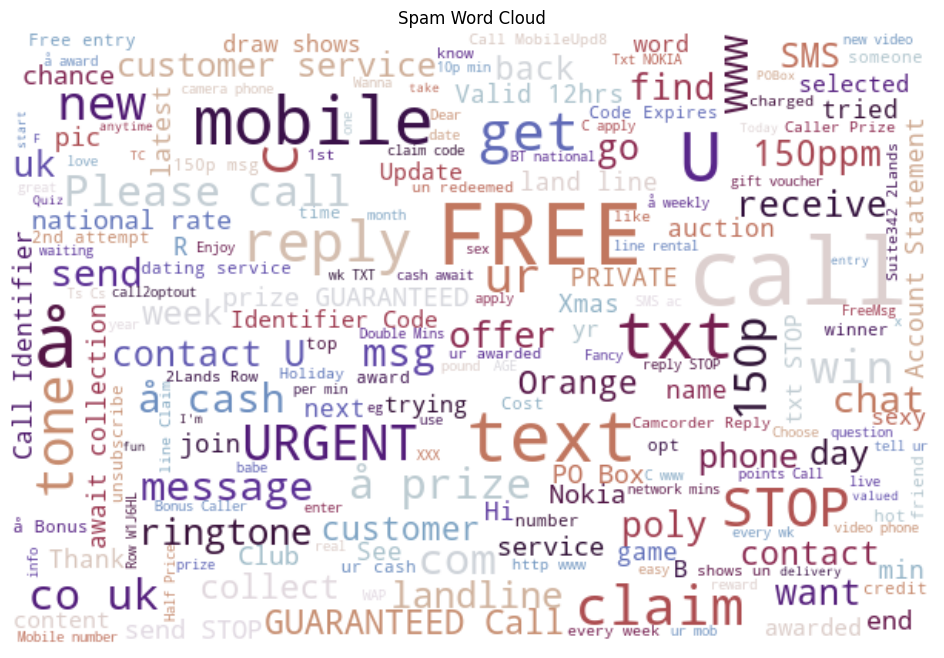

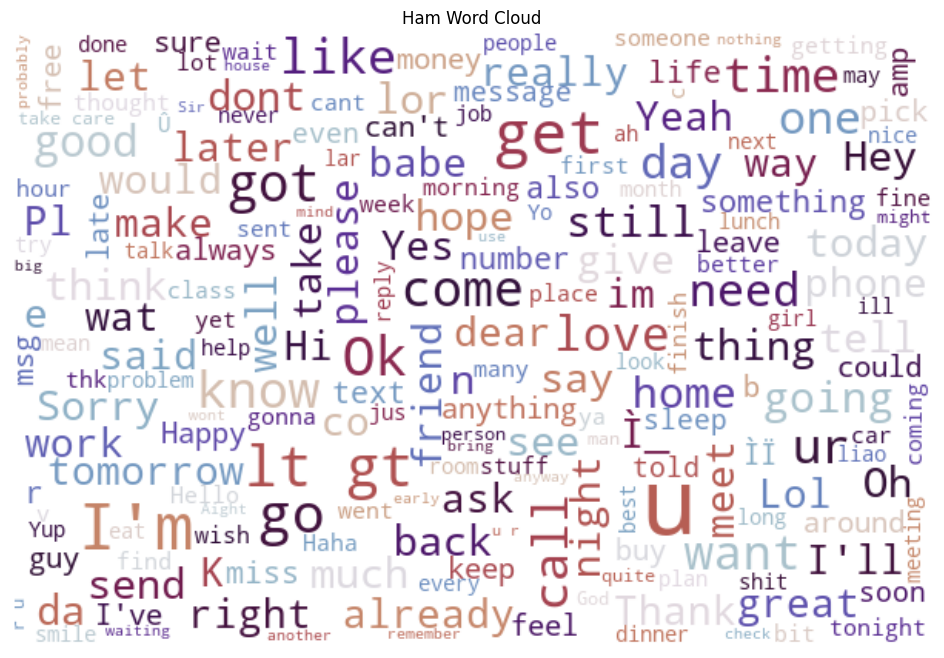

In [75]:
stop_words= set(stopwords.words("english"))

wc = WordCloud(width=600,
               height=400,
               # max_words=100,
               stopwords=stop_words,
               background_color='white',
               max_font_size=60,
               colormap='twilight')
spam = emailSMSData.query("target=='spam'").text.str.cat(sep=" ")

ham = emailSMSData.query("target=='ham'").text.str.cat(sep=" ")


wc.generate(spam)
plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Spam Word Cloud")
plt.show();


wc.generate(ham)
plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Ham Word Cloud")
plt.show();

In [76]:
emailSMSData['charcaters_count'] = emailSMSData['text'].apply(len)
emailSMSData

,target,text,charcaters_count
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161
5568,ham,Will Ì_ b going to esplanade fr home?,37
5569,ham,"Pity, * was in mood for that. So...any other s...",57
5570,ham,The guy did some bitching but I acted like i'd...,125


In [77]:
emailSMSData['words_count'] = emailSMSData['text'].apply(lambda x:len(nltk.word_tokenize(x)))
emailSMSData

,target,text,charcaters_count,words_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,24
1,ham,Ok lar... Joking wif u oni...,29,8
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,ham,U dun say so early hor... U c already then say...,49,13
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,35
5568,ham,Will Ì_ b going to esplanade fr home?,37,9
5569,ham,"Pity, * was in mood for that. So...any other s...",57,15
5570,ham,The guy did some bitching but I acted like i'd...,125,27


In [78]:
emailSMSData['sentence_count'] = emailSMSData['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
emailSMSData

,target,text,charcaters_count,words_count,sentence_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,35,4
5568,ham,Will Ì_ b going to esplanade fr home?,37,9,1
5569,ham,"Pity, * was in mood for that. So...any other s...",57,15,2
5570,ham,The guy did some bitching but I acted like i'd...,125,27,1


In [79]:
spam = emailSMSData.query("target=='spam'")['words_count'].reset_index()
ham = emailSMSData.query("target=='ham'")['words_count'].reset_index()

fig = make_subplots(rows=1, cols=2, subplot_titles=("Spam word count distribution", "Ham word count distribution"))
fig.add_trace(go.Histogram(x=spam['words_count'], marker_color='#73a1c7'),row=1, col=1)
fig.add_trace(go.Histogram(x=ham['words_count'],  marker_color='#c47d7d' ),row=1, col=2)
fig.update_layout(height=600, title_text="Word count distrbution", title_x = 0.5, showlegend=False, template='plotly_white')
fig.show()

In [80]:
spam = emailSMSData.query("target=='spam'")['charcaters_count'].reset_index()
ham = emailSMSData.query("target=='ham'")['charcaters_count'].reset_index()

fig = make_subplots(rows=1, cols=2, subplot_titles=("Spam characters count distribution", "Ham characters count distribution"))
fig.add_trace(go.Histogram(x=spam['charcaters_count'], marker_color='#73a1c7'),row=1, col=1)
fig.add_trace(go.Histogram(x=ham['charcaters_count'], marker_color='#c47d7d' ),row=1, col=2)
fig.update_layout(height=600, title_text="Charcters count distrbution", title_x = 0.5, showlegend=False ,template='plotly_white')
fig.show()

In [81]:
spam = emailSMSData.query("target=='spam'")['sentence_count'].reset_index()
ham = emailSMSData.query("target=='ham'")['sentence_count'].reset_index()

fig = make_subplots(rows=1, cols=2, subplot_titles=("Spam sentences count distribution", "Ham sentences count distribution"))
fig.add_trace(go.Histogram(x=spam['sentence_count'], marker_color='#73a1c7'),row=1, col=1)
fig.add_trace(go.Histogram(x=ham['sentence_count'], marker_color='#c47d7d' ),row=1, col=2)
fig.update_layout(height=600, title_text="Charcters count distrbution", title_x = 0.5, showlegend=False ,template='plotly_white')
fig.show()

In [82]:
# Replace ham with 0 and spam 1
emailSMSData = emailSMSData.replace('spam', 1)
emailSMSData = emailSMSData.replace('ham', 0)

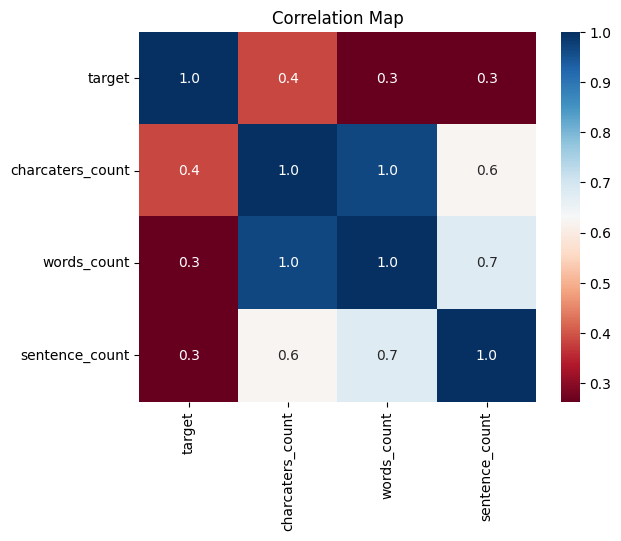

In [83]:
sns.heatmap(emailSMSData.corr(), annot=True, fmt=".1f", cmap='RdBu')
plt.title("Correlation Map")
plt.show()

### Data Cleaning

**cleanText Function:**

This function created to used in cleaning any unwanted characters in the text column.
In this function we used regural expression to match an replace the unwanted characters in each text message.

This function contains the following:
- Remove any white space in the bigening of the messaege.
- Remove any URL that is in the messege.
- Remove any username start with @.
- Remove any special characters like @,# or % ...ect.


In [84]:
def cleanText(text):
    # Create a regular experssion pattern for whitespaces '\s', + means there is one or more charater after the whitespace 
    # ==> as result this pattern remove the whitespace at the begining of string
    whitespace = re.compile(r"\s+") 


    # Create a regular experssion pattern for web addresses 
    # (?i) ==> for case insinstive
    # (s) ==> means either http or https
    # \/\/ ==> means douple slash 
    #[a-z0-9.~_\-\/]+ ==> means set of characters between a-z and 0-9, . except newlines , ~_ include underscore and \, + one or more characters
    web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")

    # Create a regular experssion pattern for users ids
    # (?i) ==> for case insinstive 
    # @ ==> means contains @ character
    # [a-z0-9_]+ ==> means contains characters a to z and digits 0 to 9 and underscore
    user = re.compile(r"(?i)@[a-z0-9_]+")

    # to replace the . in text with empty string
    text = text.replace('.', '')

    # Apply the whitespace pattern into the text using sub
    text = whitespace.sub(' ', text)

    # Apply web addreses pattern into the text using sub
    text = web_address.sub('', text)

    # Apply user pattern into the text using pattern
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    return text.lower()
emailSMSData.text =  [cleanText(item) for item in emailSMSData.text]
#print(spam_data)

**Tokenization**:

Dealing with the text in any deep learning models needs special handling using NLP. due to that, we choose to handle the text in our data using tokenization. Tokenization is the process of converting the text into smaller units called a token, to make it easier to handle them separately. In Python, the Keras library offers a Tokenizer method that is built inside Keras .preprocessing.text.

**Tokenization will be done through multiple steps:**
1. Initialize the Tokenizer and pass oov_token: in this process, we initialize the tokenizer and give it an oov_token name which is
OOV will be reserved for out-of-vocabulary words.

2. Fit text into tokenizer using fit_on_text: in this step, the text will be handed to our tokenizer to help it create its own dictionary 
that will be used as a reference, later on, to match our text into its corresponding indices.

3. Conver the text messages into sequences of integers using texts_to_sequences: in this step, the tokenizer will take the text messages in the dataset and start to match and replace the words in the text messages with its corresponding index using the dictionary that was created in step 2.

4. Padding the sequences to balance the data using pad_sequences: in this step, the pad_sequences will take the sequences created in step 3 and start to pad 0 into sequences to make them all of the same length that will be specified using the maxlen parameter.



#### 1. Initialize the Tokenizer and pass oov_token 

In [85]:
tokenizer = Tokenizer(oov_token='<OOV>')

#### 2. Fit text into tokenizer using fit_on_text

In [86]:
tokenizer.fit_on_texts(emailSMSData.text)
vocab = tokenizer.word_index 
vocabCount = len(vocab)+1 

#### 3. Conver the text messages into sequences of integers using texts_to_sequences

In [87]:
textSequences = tokenizer.texts_to_sequences(emailSMSData.text)

#### 4. Padding the sequences to balance the data using pad_sequences

In [88]:
len(max(textSequences, key=len)) # To determine the best maxlen for padding 

171

In [89]:
finalDataFrame = pad_sequences(textSequences, padding='pre', maxlen=171) 
target = emailSMSData.target
dim = finalDataFrame.shape[1] # This will be the input shape later in the model

## Model Building

### Using train_test_split to split our data into 80% 20%

In [90]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain,yTest = train_test_split(finalDataFrame, target, test_size=0.2, random_state=0)

### Build Sequential Model

**In our model buillding:** we use Deep Learning model called Sequential which is suitable for our case. Sequential models usally used with data that have exactly one input and output. Sequential model will be used as baseline for our model and then added the layers in top of it. 

**The structure of our layers is as follow:**
- Input Layer using Embedding Layer: used with text layer to make it easier for the model to learn about the words in dataset by creating a vector for each word that as the len of output_dim (it is similar to one hot encoding but for text)
- GlobalAveragePooling1D Layer:
- 2 Hidden Dense Layers:
- Output Layer:

In [91]:
#xTrain.shape, yTrain.shape, xTest.shape, yTest.shape
model = tf.keras.models.Sequential() #sequential why??
model.add(tf.keras.layers.Embedding(input_dim=vocabCount, output_dim=32, input_length=dim))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

### Compiled Model

In our project we compile the model using the following:
- loss function as binary_entropy => binary classification
- optimize: Adam
- metrics: accuracy

In [92]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(xTrain, yTrain, epochs=10, shuffle=True)

Epoch 1/10
130/130 [==============================] - 1s 3ms/step - loss: 0.4350 - accuracy: 0.8779
Epoch 2/10
130/130 [==============================] - 0s 3ms/step - loss: 0.3422 - accuracy: 0.8781
Epoch 3/10
130/130 [==============================] - 0s 2ms/step - loss: 0.2811 - accuracy: 0.8803
Epoch 4/10
130/130 [==============================] - 0s 2ms/step - loss: 0.1034 - accuracy: 0.9676
Epoch 5/10
130/130 [==============================] - 0s 2ms/step - loss: 0.0495 - accuracy: 0.9855
Epoch 6/10
130/130 [==============================] - 0s 3ms/step - loss: 0.0364 - accuracy: 0.9898
Epoch 7/10
130/130 [==============================] - 0s 2ms/step - loss: 0.0304 - accuracy: 0.9913
Epoch 8/10
130/130 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 0.9944
Epoch 9/10
130/130 [==============================] - 0s 3ms/step - loss: 0.0186 - accuracy: 0.9949
Epoch 10/10
130/130 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 0.9961

### Evaluate Model

In this section we evalute the model using evaluate function.

In [93]:
y_pred = model.predict(xTest)
print()
print('Evaluate the mode')
eval = model.evaluate(xTest, yTest)
print('Test Loss: ', eval[0])
print('Test Accuracy: ', eval[1])


Evaluate the mode
33/33 [==============================] - 0s 519us/step - loss: 0.0727 - accuracy: 0.9836
Test Loss:  0.0726599469780922
Test Accuracy:  0.9835590124130249


## Save Model & Tokenizer

In [94]:
model.save('messagesModele.pkl') # To save deep learning model we use save instead of pkile.dump
pickle.dump(tokenizer, open("messagesTokenizer.pkl", "wb")) # We save tokenizer so we can use it in the website

INFO:tensorflow:Assets written to: messagesModele.pkl\assets


### Test the model on unseen data

In [95]:
loadedModel = tf.keras.models.load_model('messagesModele.pkl')
text = "Hi my name is Munirah"
processedText = cleanText(text)
finalText = pad_sequences(tokenizer.texts_to_sequences([processedText]), padding='pre', maxlen=171)
loadedModel.predict(finalText)

if model.predict(finalText) > 0.5:
    print('Spam')
else:
    print('Ham')

Ham
